# Clustering News Articles

Previously, we performed data mining knowing what we were looking for. Our use of target classes allowed us to learn how our variables model those targets during the training phase. This type of learning, where we have targets to train against, is called **supervised learning**. Here, we consider what we do without those targets. This is **unsupervised learning** and is much more of an exploratory task. Rather than wanting to classify with our model, the goal in unsupervised learning is more about exploring the data to find insights.

We will look at clustering news articles to find trends and patterns in the data. We look at how we can extract data from different websites using a link aggregation website to show a variety of news stories.

The key concepts covered in this chapter include:
- Obtaining text from arbitrary websites
- Using the reddit API to collect interesting news stories
- Cluster analysis for unsupervised data mining
- Extracting topics from documents
- Online learning for updating a model without retraining it
- Cluster ensembling to combine different models

## Obtaining news articles

We will build a system that takes a news articles and groups them together, where the groups have similar topics. Our goal is to generate 500 fake news articles in python and then cluster them to
see any major themes or concepts that occur.

## Generate news articles

In [1]:
import faker
import random
from datetime import datetime, timedelta

In [2]:
fake = faker.Faker()

In [3]:
my_word_list = [
    'danish','cheesecake','sugar',
    'Lollipop','wafer','Gummies',
    'sesame','Jelly','beans',
    'pie','bar','Ice','oat' ]

random.seed(42)
sample_size = 3
num_of_iters = 6
samples = []
for _ in range(num_of_iters):
    random_sample = random.sample(my_word_list, sample_size)
    samples.append(random_sample)

print("Fixed random sample:", samples)


Fixed random sample: [['bar', 'cheesecake', 'danish'], ['Ice', 'wafer', 'Lollipop'], ['Lollipop', 'sugar', 'cheesecake'], ['bar', 'Ice', 'beans'], ['cheesecake', 'pie', 'sesame'], ['danish', 'oat', 'cheesecake']]


In [4]:
def generate_title():
    max_words = 5  # Maximum number of words
    num_words = random.randint(1, max_words)
    return ' '.join(fake.word() for _ in range(num_words))

def generate_author():
    return f"{fake.first_name()} {fake.last_name()}"

def generate_content(sample, num_indicators=1):
    lines = []
    for _ in range(300):
        lines.append(fake.text())
    for _ in range(num_indicators):
        lines.append(fake.sentence(ext_word_list=sample))
    
    random.shuffle(lines)
    
    text = '/n'.join(lines)

    return text

In [5]:
documents = []
def generate_article(i, samples, num_indicators=1):
    docs = []
    for sample in samples:
        title = generate_title()
        author = generate_author()
        content = generate_content(sample, num_indicators)

        article = f"""
        Title: {title}
        Author: {author}

        {content}
        """
        
        docs.append(article)
    return docs

def return_docs(return_docs=60, num_indicators=1):
    dcuments = []
    for i in range(return_docs):
        dcuments += generate_article(i, samples, num_indicators)

    return dcuments

documents = return_docs()
print(len(documents))


360


In [6]:
print(documents[0][:400])


        Title: similar real
        Author: Nicholas Villarreal

        Cut amount serve movie no news. Art stop field truth common throw. Cost alone get I simple stand. Board back artist technology every leave rule discussion./nGreen speak teach kitchen nothing bag. Receive wear history.
Strategy leader practice training standard structure build. Present recent professor we. Nice tree couple gr


In [7]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [8]:
from sklearn.pipeline import Pipeline

n_clusters = 10
pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', KMeans(n_clusters=n_clusters))])


In [9]:
pipeline.fit(documents)
labels = pipeline.predict(documents)

from collections import Counter
c = Counter(labels)
for cluster_number in range(n_clusters):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

Cluster 0 contains 29 samples
Cluster 1 contains 40 samples
Cluster 2 contains 38 samples
Cluster 3 contains 43 samples
Cluster 4 contains 34 samples
Cluster 5 contains 28 samples
Cluster 6 contains 40 samples
Cluster 7 contains 37 samples
Cluster 8 contains 34 samples
Cluster 9 contains 37 samples


In [10]:
c[0]

29

In [11]:
pipeline.named_steps['clusterer'].inertia_

268.97646664392266

In [12]:
import numpy as np

inertia_scores = []
n_cluster_values = list(range(2, 10))
for n_clusters in n_cluster_values:
    print(f'starting n_clusster: {n_clusters}')
    cur_inertia_scores = []
    X = TfidfVectorizer(max_df=0.4).fit_transform(documents)
    for i in range(15):
        km = KMeans(n_clusters=n_clusters).fit(X)
        cur_inertia_scores.append(km.inertia_)
    inertia_scores.append(cur_inertia_scores)
inertia_scores = np.array(inertia_scores)

starting n_clusster: 2
starting n_clusster: 3
starting n_clusster: 4
starting n_clusster: 5
starting n_clusster: 6
starting n_clusster: 7
starting n_clusster: 8
starting n_clusster: 9


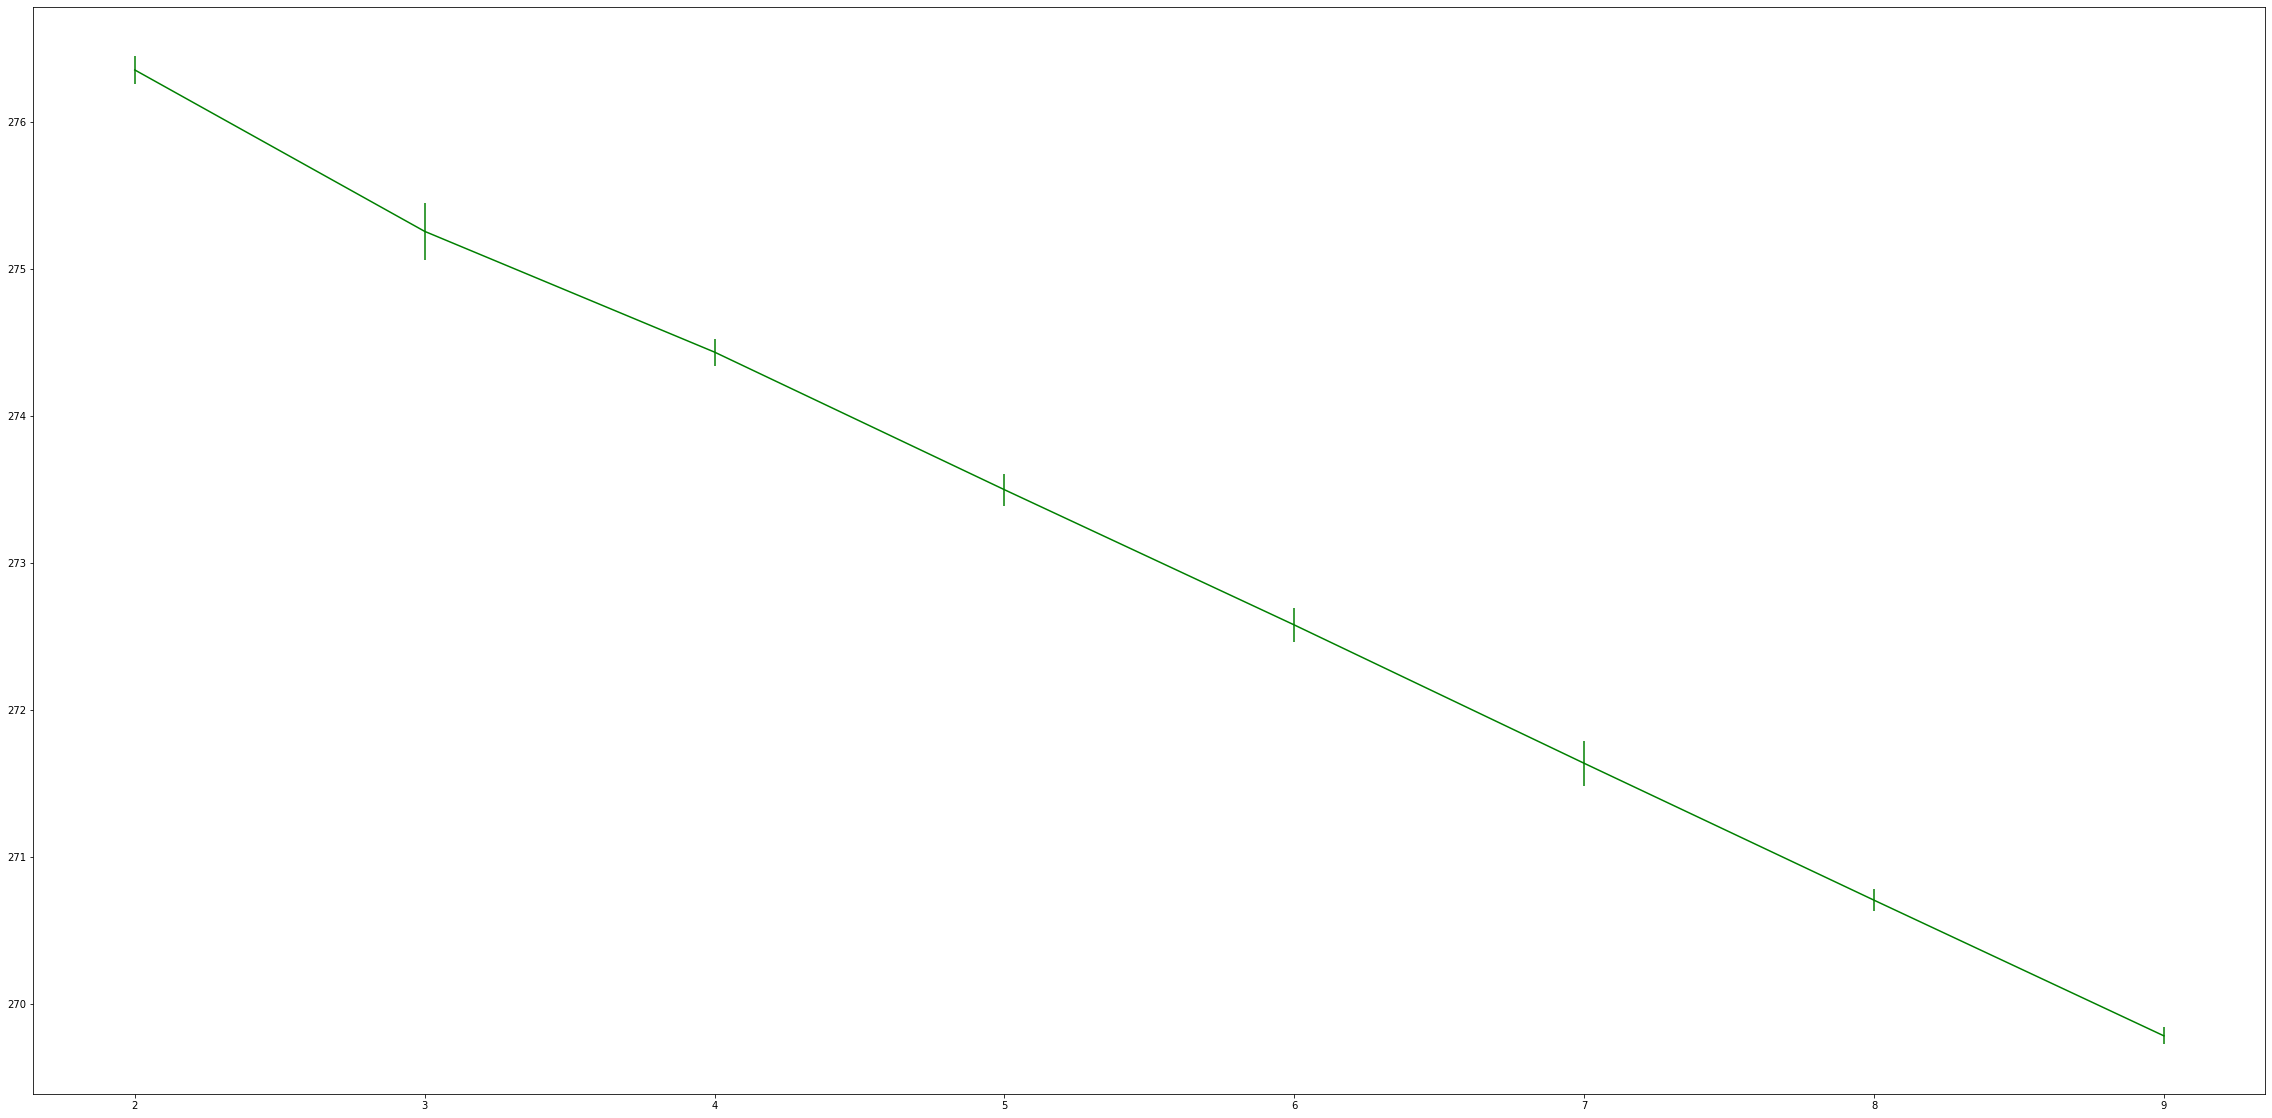

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

inertia_means = np.mean(inertia_scores, axis=1)
inertia_stderr = np.std(inertia_scores, axis=1)

fig = plt.figure(figsize=(40,20))
plt.errorbar(n_cluster_values, inertia_means, inertia_stderr, color='green')
plt.show()

In [14]:
n_clusters = 6

pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', KMeans(n_clusters=n_clusters))
                     ])
pipeline.fit(documents)

Pipeline(steps=[('feature_extraction', TfidfVectorizer(max_df=0.4)),
                ('clusterer', KMeans(n_clusters=6))])

In [15]:
labels = pipeline.predict(documents)

In [16]:
# Note: the higher the number of indicatorers the more perfect the model
# trivial_docs = return_docs(num_indicators=10)
# pipeline.fit(trivial_docs)
# trivial_labels = pipeline.predict(trivial_docs)

# from collections import Counter
# c = Counter(trivial_labels)
# for cluster_number in range(n_clusters):
#     print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

In [17]:

c = Counter(labels)

terms = pipeline.named_steps['feature_extraction'].get_feature_names()

for cluster_number in range(n_clusters):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))
    print("  Most important terms")
    centroid = pipeline.named_steps['clusterer'].cluster_centers_[cluster_number]
    most_important = centroid.argsort()
    for i in range(5):
        term_index = most_important[-(i+1)]
        print("  {0}) {1} (score: {2:.4f})".format(i+1, terms[term_index], centroid[term_index]))
    print()

Cluster 0 contains 64 samples
  Most important terms
  1) danish (score: 0.0505)
  2) nits (score: 0.0271)
  3) nopen (score: 0.0270)
  4) ncall (score: 0.0269)
  5) noutside (score: 0.0264)

Cluster 1 contains 60 samples
  Most important terms
  1) lollipop (score: 0.0287)
  2) ice (score: 0.0285)
  3) ngreen (score: 0.0282)
  4) nthing (score: 0.0274)
  5) nreturn (score: 0.0272)

Cluster 2 contains 49 samples
  Most important terms
  1) sugar (score: 0.0331)
  2) nright (score: 0.0308)
  3) lollipop (score: 0.0304)
  4) nfood (score: 0.0282)
  5) nclose (score: 0.0275)

Cluster 3 contains 70 samples
  Most important terms
  1) pie (score: 0.0372)
  2) ntown (score: 0.0277)
  3) ncreate (score: 0.0272)
  4) nperformance (score: 0.0252)
  5) nback (score: 0.0252)

Cluster 4 contains 54 samples
  Most important terms
  1) lollipop (score: 0.0602)
  2) nthus (score: 0.0315)
  3) nleft (score: 0.0314)
  4) nteam (score: 0.0292)
  5) nfour (score: 0.0263)

Cluster 5 contains 63 samples
  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
from sklearn.metrics import silhouette_score
X = pipeline.named_steps['feature_extraction'].transform(documents)
silhouette_score(X, labels)

2.459182419985236e-05

In [19]:
len(terms)

1441

In [20]:
Y = pipeline.transform(documents) 

In [21]:
km = KMeans(n_clusters=n_clusters)
labels = km.fit_predict(Y)

In [22]:
c = Counter(labels)
for cluster_number in range(n_clusters):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

Cluster 0 contains 65 samples
Cluster 1 contains 60 samples
Cluster 2 contains 48 samples
Cluster 3 contains 62 samples
Cluster 4 contains 53 samples
Cluster 5 contains 72 samples


In [23]:
silhouette_score(Y, labels)

0.34664932888264827

In [24]:
Y.shape

(360, 6)

## Evidence Accumulation Clustering

In [25]:
from scipy.sparse import csr_matrix


def create_coassociation_matrix(labels):
    rows = []
    cols = []
    unique_labels = set(labels)
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        for index1 in indices:
            for index2 in indices:
                rows.append(index1)
                cols.append(index2)
    data = np.ones((len(rows),))
    return csr_matrix((data, (rows, cols)), dtype='float')


In [26]:
C = create_coassociation_matrix(labels)

In [27]:
C

<360x360 sparse matrix of type '<class 'numpy.float64'>'
	with 21966 stored elements in Compressed Sparse Row format>

In [28]:
C.shape, C.shape[0] * C.shape[1]

((360, 360), 129600)

In [29]:
len(C.nonzero()[0]) / (C.shape[0] * C.shape[1])

0.16949074074074075

In [30]:
from scipy.sparse.csgraph import minimum_spanning_tree

In [31]:
mst = minimum_spanning_tree(C)

In [32]:
mst

<360x360 sparse matrix of type '<class 'numpy.float64'>'
	with 354 stored elements in Compressed Sparse Row format>

In [33]:
pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', KMeans(n_clusters=3))
                     ])
pipeline.fit(documents)
labels2 = pipeline.predict(documents)
C2 = create_coassociation_matrix(labels2)

In [34]:

C_sum = (C + C2) / 2
#C_sum.data = C_sum.data
C_sum.todense()

matrix([[1. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 1. , 0.5, ..., 0.5, 0.5, 1. ],
        [0. , 0.5, 1. , ..., 0. , 0.5, 0.5],
        ...,
        [0. , 0.5, 0. , ..., 1. , 0. , 0.5],
        [0. , 0.5, 0.5, ..., 0. , 1. , 0.5],
        [0. , 1. , 0.5, ..., 0.5, 0.5, 1. ]])

In [35]:
mst = minimum_spanning_tree(-C_sum)
mst

<360x360 sparse matrix of type '<class 'numpy.float64'>'
	with 359 stored elements in Compressed Sparse Row format>

In [36]:

#mst.data[mst.data < 1] = 0
mst.data[mst.data > -1] = 0
mst.eliminate_zeros()
mst

<360x360 sparse matrix of type '<class 'numpy.float64'>'
	with 342 stored elements in Compressed Sparse Row format>

In [37]:
from scipy.sparse.csgraph import connected_components
number_of_clusters, labels = connected_components(mst)

In [38]:
from sklearn.base import BaseEstimator, ClusterMixin

class EAC(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusterings=10, cut_threshold=0.5, n_clusters_range=(3, 10)):
        self.n_clusterings = n_clusterings
        self.cut_threshold = cut_threshold
        self.n_clusters_range = n_clusters_range
    
    def fit(self, X, y=None):
        C = sum((create_coassociation_matrix(self._single_clustering(X))
                 for i in range(self.n_clusterings)))
        mst = minimum_spanning_tree(-C)
        mst.data[mst.data > -self.cut_threshold] = 0
        mst.eliminate_zeros()
        self.n_components, self.labels_ = connected_components(mst)
        return self
    
    def _single_clustering(self, X):
        n_clusters = np.random.randint(*self.n_clusters_range)
        km = KMeans(n_clusters=n_clusters)
        return km.fit_predict(X)
    
    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

In [39]:

pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', EAC())])

In [40]:
pipeline.fit(documents)

Pipeline(steps=[('feature_extraction', TfidfVectorizer(max_df=0.4)),
                ('clusterer', EAC())])

In [41]:
labels = pipeline.named_steps['clusterer'].labels_

In [42]:
c = Counter(labels)
c

Counter({0: 360})

## Online Learning

In [43]:
from sklearn.cluster import MiniBatchKMeans

In [44]:
vec = TfidfVectorizer(max_df=0.4)

In [45]:
X = vec.fit_transform(documents)

In [46]:
mbkm = MiniBatchKMeans(random_state=14, n_clusters=3)
batch_size = 500

indices = np.arange(0, X.shape[0])
for iteration in range(100):
    sample = np.random.choice(indices, size=batch_size, replace=True)
    mbkm.partial_fit(X[sample[:batch_size]])

In [47]:
mbkm = MiniBatchKMeans(random_state=14, n_clusters=3)
batch_size = 10

for iteration in range(int(X.shape[0] / batch_size)):
    start = batch_size * iteration
    end = batch_size * (iteration + 1)
    mbkm.partial_fit(X[start:end])

In [48]:
labels_mbkm = mbkm.predict(X)
mbkm.inertia_

7.7423667398350755

In [49]:
km = KMeans(random_state=14, n_clusters=3)
labels_km = km.fit_predict(X)
km.inertia_

275.38373423673045

In [50]:
from sklearn.metrics import adjusted_mutual_info_score, homogeneity_score
from sklearn.metrics import mutual_info_score, v_measure_score

In [51]:
v_measure_score(labels_mbkm, labels_km)

0.01130035469616235

In [52]:
X.shape

(360, 1441)

In [53]:
labels_mbkm

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [54]:
from sklearn.feature_extraction.text import HashingVectorizer

In [55]:
class PartialFitPipeline(Pipeline):
    def partial_fit(self, X, y=None):
        Xt = X
        for name, transform in self.steps[:-1]:
            Xt = transform.transform(Xt)
        return self.steps[-1][1].partial_fit(Xt, y=y)

In [56]:
pipeline = PartialFitPipeline([('feature_extraction', HashingVectorizer()),
                             ('clusterer', MiniBatchKMeans(random_state=14, n_clusters=3))])

In [57]:
batch_size = 10

for iteration in range(int(len(documents) / batch_size)):
    start = batch_size * iteration
    end = batch_size * (iteration + 1)
    pipeline.partial_fit(documents[start:end])

In [58]:
labels = pipeline.predict(documents)
labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,